In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [28]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


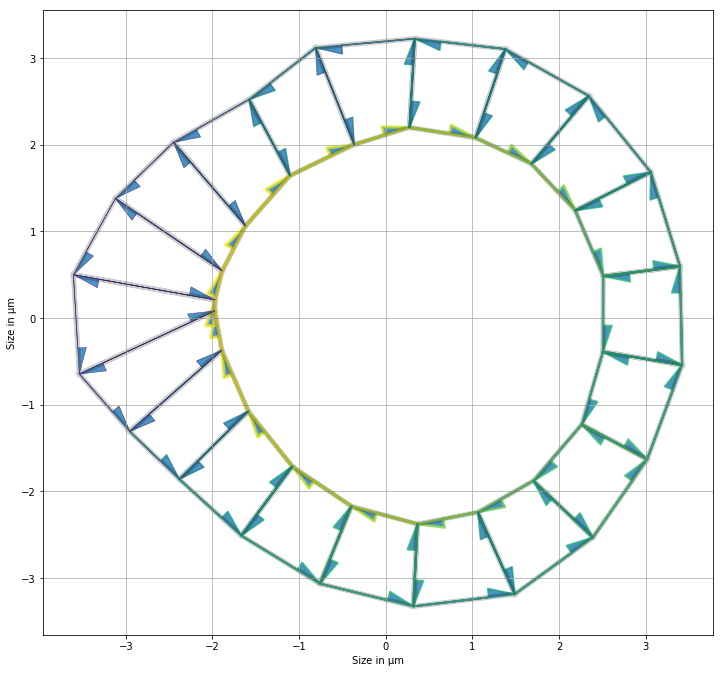

In [29]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [21]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_quad_prog.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}
slsqp_opt = {'method': 'slsqp'}
reg_weight = 1e-3
theta = 0.02

In [22]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.150
1     0.165
2     0.180
3     0.195
4     0.210
5     0.216
6     0.222
7     0.228
8     0.234
9     0.234
10    0.237
11    0.234
12    0.228
13    0.222
14    0.216
15    0.210
16    0.204
17    0.195
18    0.171
19    0.156
20    0.150
21    0.165
22    0.150
23    0.135
24    0.150
25    0.150
26    0.135
27    0.105
28    0.060
29    0.030
      ...  
50    0.030
51    0.042
52    0.063
53    0.108
54    0.087
55    0.123
56    0.117
57    0.129
58    0.138
59    0.153
60    0.165
61    0.150
62    0.132
63    0.153
64    0.153
65    0.138
66    0.102
67    0.057
68    0.027
69    0.030
70    0.042
71    0.063
72    0.108
73    0.087
74    0.123
75    0.117
76    0.129
77    0.138
78    0.153
79    0.150
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.159524
1     0.171626
2     0.153793
3     0.151092
4     0.166324
5     0.158801
6     0.133252
7     0.091433
8     0.053653
9     0.038093
10    0.042930
11    0.057900
12    0.083871
13    0.112560

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [23]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Programme quadratique avec régularisation des tensions apicales

On introduit le problème de minimisation suivant :
$$ \min ||A\mathbf{x} - \mathbf{b}||^2 $$
$$ \frac{1}{c} T_{j, k}\le T_{i, j} \le c T_{j, k} \quad \forall i,j,k \quad s.t. <i,j>, <j,k> \in \mathcal{E^a}$$

Où $c$ est une constance choisi arbitrairement et $\mathcal{E^a}$ désigne l'ensemble des edges apicaux du maillage

In [24]:
MULT = 1.5
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
def obj(var, matrix, constant):
    return np.linalg.norm(np.dot(matrix, var) - constant)**2
def make_cst_ub(edges, mult):
    return lambda x: -(x[edges[0]] - x[edges[1]]*mult)
def make_cst_lb(edges, mult):
    return lambda x: -(x[edges[1]]/mult - x[edges[0]])
cst = {}
organo3.get_extra_indices()
start_point = infer_forces(organo3, "NNLS", sup_param="areas")
for edge in organo3.apical_edges:
    couple = (edge, (edge+1)%(organo3.apical_edges.shape[0]))
    cst[(couple, 'ub')] = {'type': 'ineq',
                           'fun': make_cst_ub(couple, MULT)}
    cst[(couple, 'lb')] = {'type': 'ineq',
                           'fun': make_cst_lb(couple, MULT)}
bounds = np.concatenate((np.tile((0, 1e6), organo3.sgle_edges.shape[0]),
                         np.tile((-1e6, 1e6), organo3.Nf+1)))
bounds = np.reshape(bounds, (int(bounds.shape[0]/2), 2))
res = optimize.minimize(obj, np.ones(organo3.sgle_edges.shape[0]+organo3.Nf+1),
                        args=(matrix, constant),
                        method='SLSQP',
                        bounds=[[0, 1e6]]*60+[[-1e6,1e6]]*21,
                        constraints=cst.values())

Apical tensions:  [0.0497828  0.03490008 0.02979474 0.03785638 0.03621694 0.03351438
 0.04698898 0.07048347 0.101765   0.08039208 0.09284852 0.06878031
 0.05668288 0.03778859 0.04904423 0.04145203 0.03598093 0.03487867
 0.04121532 0.05525519] 
Basal tensions:  [0.04634604 0.03787674 0.03273176 0.0367965  0.03708476 0.03594337
 0.04499134 0.05922586 0.06954007 0.04079231 0.05221272 0.03672679
 0.03131411 0.0213545  0.02972026 0.02921294 0.02628346 0.02677998
 0.03441188 0.04897783] 
Lateral tensions:  [0.05687903 0.04508724 0.02099849 0.01861561 0.02924286 0.02396061
 0.03195223 0.05188136 0.06085959 0.02444401 0.02880832 0.03869538
 0.03103631 0.02689075 0.00965921 0.0281297  0.01538914 0.01460113
 0.02145244 0.04885688] 
Area elasticity:  [0.06323946 0.03668704 0.02449505 0.03774777 0.03622898 0.03100089
 0.05016188 0.07086065 0.08102809 0.04657326 0.06288174 0.04289051
 0.03713065 0.01375617 0.03298185 0.0281203  0.02104373 0.02183984
 0.03747819 0.07020826] 
Lumen area elasticity:  

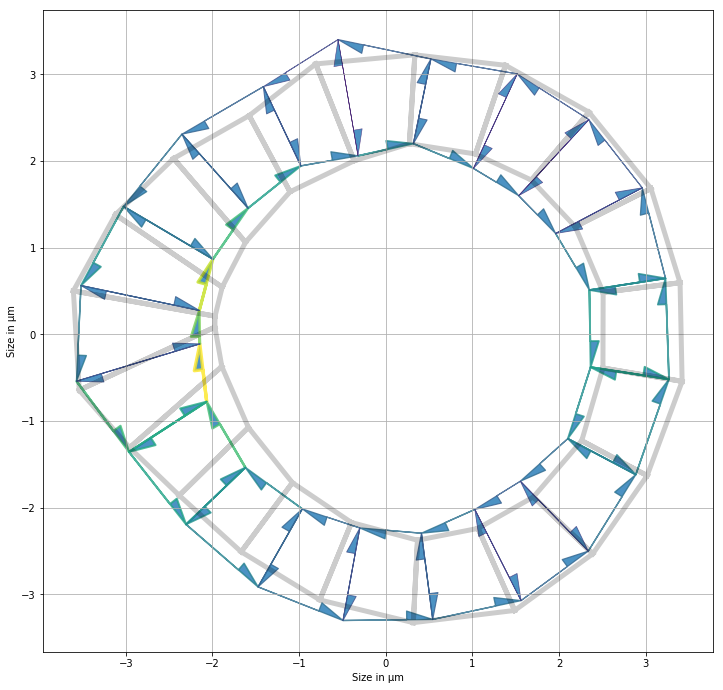

In [25]:
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 res.x[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + res.x[3*organo3.Nf:4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + res.x[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', res.x[organo3.apical_edges],
      '\nBasal tensions: ', res.x[organo3.basal_edges],
      '\nLateral tensions: ', res.x[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', res.x[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', organo3_eq_cst.settings['lumen_volume'] + res.x[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-res.x))

In [26]:
organo3_eq_cst.settings['lumen_prefered_vol'], organo3_eq_cst.settings['lumen_volume']

(31.158950282119427, 31.146765872309913)

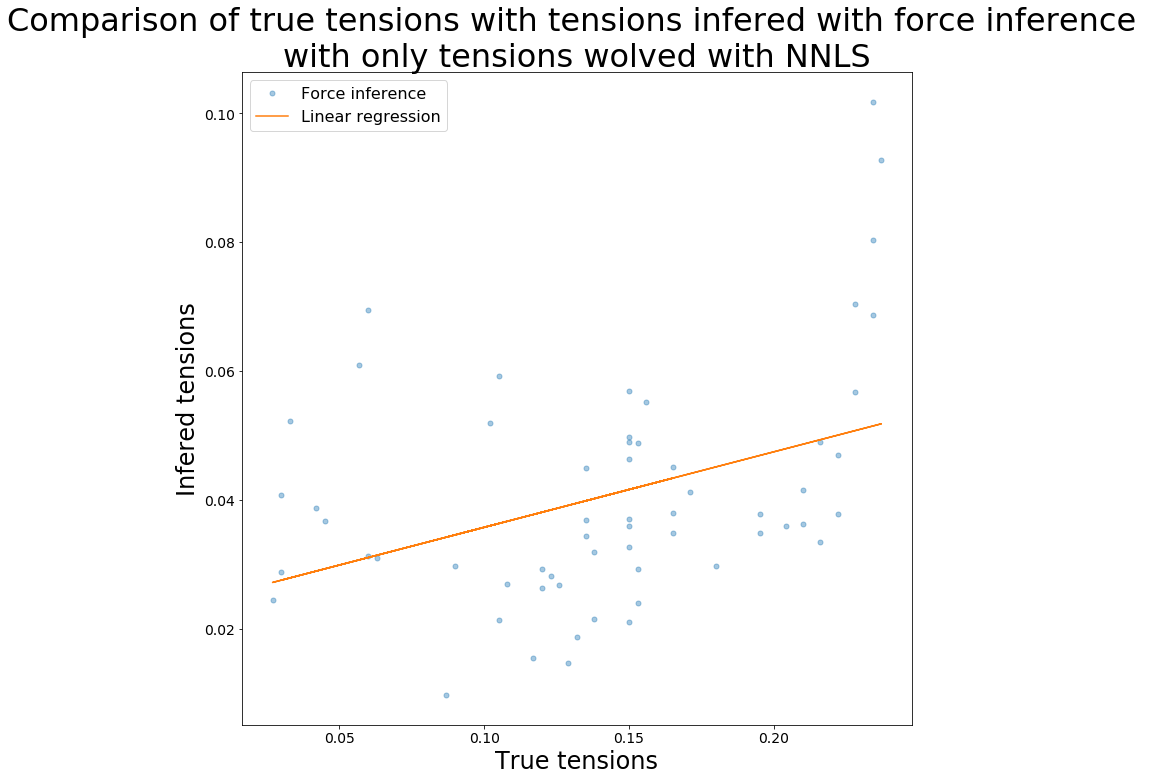

R value : 0.3860238470673775 
Standard error : 0.014264000322446064


In [27]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

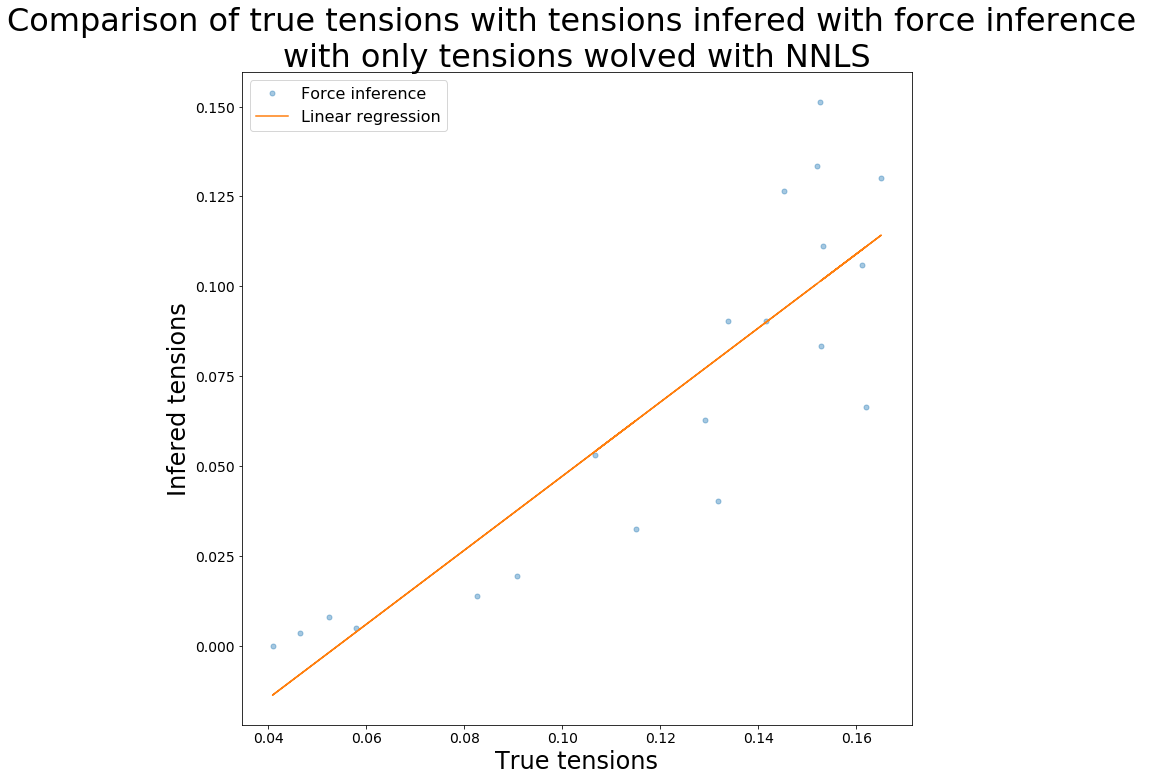

R value : 0.8744352008544253 
Standard error : 0.011742062248858936


In [11]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  res.x[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [12]:
iprint_file = "../../assets/dist_at_each_f_ev/4_03_quad_prog_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, res.x[:3*to_opt_organo.Nf]),
                                                   to_opt_organo.face_df.area + res.x[3*to_opt_organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + res.x[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

16.22711916647527 [0.74281913 0.5275632  0.57462245 0.79064008 0.75752779 0.41128008
 0.25100265 0.12548274 0.24379902 0.36236852 0.46002896 0.4977896
 0.17900354 0.08084969 0.31564852 0.33288171 0.50385229 0.82643631
 0.69499197 0.43889329 0.79367298 0.51137293 0.25616683 0.759434
 0.55471019 0.09344349 0.2494837  0.18739977 0.06640487 0.34327758
 0.35690372 0.16610919 0.25916659 0.14817671 0.32856335 0.31784203
 0.19400093 0.71826925 0.52427064 0.28096888 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

16.226737796703688 [0.73756247 0.52508948 0.57581128 0.79055592 0.75631722 0.41116913
 0.25271501 0.12631147 0.24565271 0.36552877 0.46236683 0.49773672
 0.18024619 0.08158961 0.31619038 0.3336596  0.50422989 0.82497666
 0.69671252 0.43636815 0.78948451 0.50783832 0.25895641 0.76084061
 0.55172505 0.09394683 0.25195372 0.18860868 0.06730777 0.34552284
 0.356231   0.16674821 0.25563132 0.14776339 0.32917991 0.32077662
 0.19273348 0.71741026 0.52558674 0.27770211 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.22875313112578 [0.75513267 0.53050233 0.57457948 0.7907607  0.76139449 0.41136944
 0.24654745 0.12818987 0.24514928 0.35748222 0.45783486 0.4976043
 0.17419939 0.07743932 0.31868419 0.33200696 0.50142713 0.83119721
 0.68814791 0.44066792 0.79922884 0.51642441 0.25030991 0.75674989
 0.56441728 0.09110841 0.24229715 0.18441003 0.0687818  0.33890171
 0.35784266 0.16052943 0.26422183 0.14933481 0.33060282 0.30890537
 0.19701569 0.71946853 0.52171558 0.28616989 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

16.19491283626855 [0.73754521 0.52403607 0.57426199 0.78897227 0.75501967 0.41008076
 0.25172405 0.1264585  0.24526032 0.36495062 0.46170572 0.49763313
 0.17943734 0.08204337 0.31616192 0.33273508 0.50248262 0.82355857
 0.69416981 0.43641958 0.78832364 0.50691409 0.2585847  0.75890065
 0.55130877 0.09302263 0.25078871 0.18758864 0.0673615  0.34462147
 0.35615895 0.1658003  0.2560965  0.14743906 0.32817256 0.31912059
 0.19249903 0.71584877 0.52452446 0.27718121 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.199653186050757 [0.77280007 0.55035123 0.57094578 0.78357484 0.76992457 0.4073536
 0.23769797 0.12488844 0.23792637 0.34162527 0.44758743 0.49615981
 0.16848424 0.07309248 0.31791196 0.32301739 0.50176043 0.82843031
 0.6938091  0.44480548 0.81658698 0.5358263  0.22781873 0.7532864
 0.57300126 0.08945025 0.22906497 0.18086078 0.06609219 0.32796729
 0.3601968  0.1542027  0.2759947  0.14467677 0.33194649 0.29712695
 0.2060771  0.72426843 0.50953479 0.30352656 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

16.264004636666705 [0.7691683  0.54850371 0.57283755 0.7887116  0.76962769 0.4103717
 0.24157873 0.12366071 0.23695044 0.34594851 0.45028466 0.49738323
 0.17079597 0.07395212 0.31661725 0.32654082 0.50462232 0.83126742
 0.69675721 0.44979524 0.81596962 0.53401757 0.2340113  0.75656586
 0.5719873  0.09173654 0.23410273 0.18284733 0.06470494 0.33091354
 0.36025707 0.15900849 0.27462721 0.14700536 0.33136193 0.30261289
 0.20420757 0.72654043 0.51365252 0.30249924 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.244552167970475 [0.77059528 0.55153249 0.57139265 0.7865627  0.76961222 0.40898843
 0.23959231 0.12435858 0.23746348 0.34392626 0.44922534 0.49659635
 0.16982078 0.07320367 0.31756608 0.324815   0.50352532 0.83024563
 0.69479543 0.44985648 0.81656331 0.536943   0.23004912 0.75498038
 0.57353523 0.09041742 0.23140396 0.18250102 0.06562537 0.32966196
 0.36095464 0.15707934 0.27550804 0.14572315 0.33242657 0.30033745
 0.20498744 0.72604501 0.51126475 0.30487051 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.27522306716224 [0.77723465 0.5527196  0.57126503 0.78771271 0.77218661 0.41103883
 0.23995856 0.12330448 0.23616982 0.34162902 0.44723178 0.49787646
 0.16931626 0.07330131 0.31618872 0.32593111 0.50441717 0.83202041
 0.69688514 0.45051936 0.82290671 0.53842085 0.22969721 0.75567947
 0.57476359 0.09178697 0.23169629 0.1818789  0.0635772  0.32875785
 0.36124724 0.15815005 0.27823168 0.14790702 0.33183752 0.29986173
 0.20596627 0.72784481 0.51179822 0.30630645 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.101711128802144 [0.72394334 0.51486426 0.5735226  0.78442204 0.74950581 0.4069033
 0.25295298 0.13037222 0.25243    0.3690361  0.46502836 0.49433701
 0.18353703 0.08271766 0.318493   0.33372553 0.49792316 0.81677016
 0.68978464 0.42961757 0.77414638 0.49467203 0.26483985 0.75554174
 0.54531092 0.09046897 0.2513709  0.18788219 0.07146816 0.34832176
 0.35417716 0.16410138 0.24770578 0.14433996 0.32921548 0.31952945
 0.18857274 0.70936889 0.52423609 0.26655451 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.226986166249404 [0.74280755 0.52754936 0.57461988 0.7906337  0.75752095 0.41127683
 0.25100335 0.12549012 0.24380905 0.36237152 0.46003046 0.49778746
 0.17900755 0.08084793 0.3156509  0.33288501 0.50384543 0.82643046
 0.69497925 0.43888195 0.79365779 0.51135798 0.25617538 0.75942716
 0.5547035  0.09343929 0.24948499 0.18739968 0.06641165 0.34328196
 0.35689926 0.16610478 0.25915486 0.14817635 0.32856599 0.31784055
 0.19399501 0.71825823 0.52427046 0.28095257 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.292152070780478 [0.76746532 0.54632636 0.57373549 0.79070524 0.76871926 0.41249989
 0.2444574  0.12416051 0.2391752  0.34768843 0.45118489 0.49849668
 0.17326359 0.07411696 0.31597346 0.3297812  0.50564194 0.83230572
 0.69824859 0.44809915 0.81562541 0.53042689 0.23835422 0.75801861
 0.57071425 0.09277945 0.23717878 0.18451024 0.063489   0.33363726
 0.35948782 0.16120878 0.27236299 0.14866224 0.33175628 0.30601804
 0.20252311 0.72692066 0.51675734 0.29967542 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.22711916647527 [0.74281913 0.5275632  0.57462245 0.79064008 0.75752779 0.41128008
 0.25100265 0.12548274 0.24379902 0.36236852 0.46002896 0.4977896
 0.17900354 0.08084969 0.31564852 0.33288171 0.50385229 0.82643631
 0.69499197 0.43889329 0.79367298 0.51137293 0.25616683 0.759434
 0.55471019 0.09344349 0.2494837  0.18739977 0.06640487 0.34327758
 0.35690372 0.16610919 0.25916659 0.14817671 0.32856335 0.31784203
 0.19400093 0.71826925 0.52427064 0.28096888 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

16.22711916647527 [0.74281913 0.5275632  0.57462245 0.79064008 0.75752779 0.41128008
 0.25100265 0.12548274 0.24379902 0.36236852 0.46002896 0.4977896
 0.17900354 0.08084969 0.31564852 0.33288171 0.50385229 0.82643631
 0.69499197 0.43889329 0.79367298 0.51137293 0.25616683 0.759434
 0.55471019 0.09344349 0.2494837  0.18739977 0.06640487 0.34327758
 0.35690372 0.16610919 0.25916659 0.14817671 0.32856335 0.31784203
 0.19400093 0.71826925 0.52427064 0.28096888 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

16.22711916647527 [0.74281913 0.5275632  0.57462245 0.79064008 0.75752779 0.41128008
 0.25100265 0.12548274 0.24379902 0.36236852 0.46002896 0.4977896
 0.17900354 0.08084969 0.31564852 0.33288171 0.50385229 0.82643631
 0.69499197 0.43889329 0.79367298 0.51137293 0.25616683 0.759434
 0.55471019 0.09344349 0.2494837  0.18739977 0.06640487 0.34327758
 0.35690372 0.16610919 0.25916659 0.14817671 0.32856335 0.31784203
 0.19400093 0.71826925 0.52427064 0.28096888 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

16.107963282339007 [0.72670415 0.51957551 0.58055821 0.78318296 0.74868383 0.40631452
 0.25493203 0.13055768 0.25397955 0.36113235 0.45626705 0.49445892
 0.18291746 0.07511435 0.31905459 0.33749918 0.50132082 0.81648268
 0.69476413 0.42968198 0.77645933 0.49667616 0.26091212 0.75700518
 0.54843153 0.09113022 0.24952595 0.19019865 0.06654596 0.34664189
 0.34795443 0.16513049 0.2436733  0.14686864 0.33251197 0.3190583
 0.19095215 0.71268721 0.52516823 0.2672496  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

15.948864891261513 [0.69765901 0.50626398 0.5778875  0.77210326 0.73767892 0.39800387
 0.26072892 0.12896105 0.25774098 0.36530978 0.4564205  0.48758791
 0.19332075 0.08225055 0.31514695 0.33878036 0.49950673 0.79412739
 0.7037723  0.42259429 0.75235467 0.4781866  0.27004033 0.75740055
 0.52492294 0.09268126 0.25669895 0.19318159 0.06389349 0.35311245
 0.34292637 0.17204769 0.23074285 0.14179199 0.32931561 0.32743719
 0.18453459 0.70368157 0.5235048  0.2545644  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

15.750157505557587 [0.72855083 0.51941381 0.56490335 0.76748087 0.73526714 0.39173823
 0.23578652 0.12192742 0.23311331 0.3510493  0.44816421 0.48763627
 0.1740204  0.0853457  0.31169912 0.31348771 0.48387174 0.8011828
 0.68091713 0.43123155 0.77643895 0.50112766 0.23937754 0.73516764
 0.54863932 0.07942507 0.2279029  0.17836349 0.0616724  0.32775573
 0.35270378 0.15730551 0.26416448 0.13459897 0.3181633  0.30020303
 0.1904052  0.70038827 0.50872417 0.28084267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

15.909022067052618 [0.73187331 0.52415946 0.56723487 0.77352153 0.74408053 0.40184118
 0.24427815 0.1242499  0.24412418 0.34649665 0.44305118 0.4897558
 0.17931334 0.07545753 0.31314853 0.32708794 0.48973669 0.81025625
 0.6849757  0.43410254 0.7833484  0.50289349 0.24861701 0.74026327
 0.54937008 0.08516735 0.23756055 0.18358109 0.06242035 0.33599639
 0.34908318 0.16242564 0.25464378 0.14345025 0.32608439 0.30848392
 0.19092668 0.70715546 0.5133567  0.27544882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

15.728557689240397 [0.74229138 0.52662612 0.56397335 0.7625753  0.73902083 0.38958319
 0.23338368 0.11619117 0.23435767 0.33031291 0.44233289 0.47967649
 0.16111007 0.07702858 0.30899228 0.31718033 0.48507164 0.81372082
 0.67602    0.43379462 0.78686382 0.51295821 0.23729657 0.74028399
 0.54097991 0.08048503 0.23340289 0.17546908 0.05857668 0.31949063
 0.34254551 0.15671774 0.26040629 0.14582381 0.31548664 0.30424459
 0.18939951 0.70430327 0.50774998 0.28283021 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.110851336201627 [0.73550127 0.51679019 0.57680514 0.78200719 0.75347239 0.40600515
 0.24979078 0.13014982 0.25413069 0.35823709 0.45454996 0.4950427
 0.17847019 0.07757313 0.31868152 0.33198662 0.49636188 0.82107485
 0.68942875 0.43400433 0.7857031  0.49951325 0.25879834 0.75546151
 0.54847526 0.09221967 0.24982914 0.18564815 0.07137611 0.34439134
 0.35120041 0.16392079 0.25040646 0.15085496 0.32837093 0.31738453
 0.19108313 0.71039843 0.52314141 0.27261077 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.05155516994182 [0.74844684 0.53036895 0.57661558 0.77940088 0.75371563 0.40296097
 0.24040024 0.1262083  0.24530481 0.34721436 0.45585367 0.4972186
 0.16578395 0.07305303 0.32334153 0.322792   0.49471883 0.81991121
 0.6869744  0.43226412 0.79715392 0.51541114 0.24234058 0.74965594
 0.55640762 0.08502407 0.23874273 0.18011578 0.06843611 0.33497955
 0.35561748 0.15768282 0.25822571 0.14856984 0.33043358 0.30749506
 0.19641157 0.71311463 0.51153974 0.28164943 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

16.16588963992417 [0.75787414 0.54056237 0.57627266 0.78779433 0.76169966 0.40558987
 0.24131982 0.12348146 0.24314064 0.34228014 0.44647006 0.49444685
 0.17333785 0.07434783 0.31649341 0.32775247 0.49690074 0.82819688
 0.696711   0.44538583 0.80974341 0.52305365 0.24658049 0.7566651
 0.56124107 0.08688094 0.23749663 0.18228702 0.0647797  0.33413484
 0.35273489 0.15971091 0.26243503 0.1461713  0.32861483 0.30863264
 0.19506666 0.72164131 0.51902984 0.28893135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

16.274226220007208 [0.75248557 0.54025875 0.58621392 0.79550153 0.76267535 0.40773644
 0.24829512 0.12454788 0.24168623 0.35429437 0.46614073 0.487894
 0.17138658 0.0741159  0.31794206 0.3356003  0.50423592 0.83354989
 0.7068931  0.44125421 0.80385471 0.52017867 0.25532605 0.76903544
 0.55588006 0.0897717  0.24856028 0.18799264 0.06458595 0.34065945
 0.3521868  0.15119615 0.25147719 0.144235   0.33316551 0.32123666
 0.19282706 0.72902055 0.52600498 0.28432352 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

16.263444662250507 [0.7043859  0.50808096 0.58646387 0.78951216 0.75095956 0.40600192
 0.2669381  0.13635879 0.26971619 0.38064241 0.47073295 0.49813524
 0.19084304 0.07890972 0.32516918 0.34512008 0.50897485 0.81153382
 0.71030445 0.42400344 0.75997247 0.48201456 0.28525616 0.77250006
 0.53303533 0.09948282 0.26988439 0.19888008 0.07668886 0.36585666
 0.34857577 0.17237087 0.2218785  0.14827461 0.34032289 0.33912265
 0.18469736 0.71266593 0.53632511 0.25285295 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

9.19029603355218 [0.04696419 0.15620944 0.36434338 0.36489198 0.30410471 0.10108005
 0.17175424 0.21589272 0.33478529 0.44242526 0.46388847 0.44686573
 0.3739075  0.27322148 0.28694474 0.14294906 0.10732164 0.31091562
 0.3402665  0.20240099 0.09309226 0.04087289 0.27308002 0.35185437
 0.20983858 0.1061473  0.16967912 0.16868473 0.13802696 0.28598859
 0.26357006 0.11299715 0.08575548 0.14184997 0.22508236 0.24918529
 0.16206069 0.28475214 0.29323457 0.08341053 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

16.31279932391122 [0.74919924 0.53928311 0.58126236 0.79040311 0.7645745  0.41243359
 0.25095671 0.12286944 0.24766385 0.35049192 0.46578435 0.49753862
 0.16675045 0.07236192 0.31803428 0.33518574 0.50914618 0.84052807
 0.69725425 0.4424093  0.80449604 0.51957696 0.25300718 0.76549909
 0.5570963  0.09575308 0.25316604 0.18971485 0.06801038 0.33933097
 0.35391912 0.16709299 0.25401589 0.15732504 0.32983979 0.32282669
 0.19346258 0.72667576 0.52490805 0.28295155 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.368069636325476 [0.75309918 0.54178147 0.57650682 0.7877348  0.76522721 0.4184609
 0.25738456 0.12606641 0.25255009 0.34516873 0.44724069 0.50052297
 0.18104687 0.06010273 0.31658706 0.34426694 0.51849181 0.83714674
 0.69498969 0.44238952 0.80053766 0.52524203 0.24741467 0.76600164
 0.55864898 0.10207216 0.2551802  0.19497661 0.06237023 0.34117779
 0.34933426 0.1819693  0.25103241 0.16431424 0.33683825 0.32127884
 0.20205602 0.72880945 0.52221732 0.2898324  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

15.486863132756183 [0.71172156 0.49774852 0.5598323  0.75698056 0.72291596 0.38357702
 0.23617791 0.12602843 0.24586914 0.34241685 0.43909338 0.47980652
 0.17814164 0.08004292 0.31111091 0.31712689 0.47213701 0.78892762
 0.66837142 0.41684039 0.75746673 0.47890233 0.25575498 0.72901096
 0.52591823 0.07651982 0.2356278  0.17513674 0.06459638 0.33212012
 0.33956804 0.15528821 0.24093615 0.13768228 0.31470054 0.30312068
 0.1806     0.68339771 0.50885894 0.25678953 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.241393476653155 [0.75278141 0.53016157 0.58041523 0.79297861 0.75821833 0.40947612
 0.25148802 0.12235663 0.24459513 0.35080111 0.45408704 0.49234674
 0.18011491 0.07333014 0.31278971 0.33987747 0.50619588 0.82711264
 0.70454753 0.44047209 0.80496561 0.51466866 0.25931863 0.76397755
 0.55089506 0.09221185 0.25133976 0.1881512  0.05987076 0.3405817
 0.34707652 0.16754518 0.24960587 0.15526722 0.33006518 0.32047972
 0.19083938 0.72087972 0.53027265 0.27923495 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.19627082677953 [0.66178447 0.48301372 0.59642186 0.78118471 0.74209803 0.40826149
 0.27733789 0.15453077 0.30134412 0.39113307 0.47975879 0.49906242
 0.20454758 0.05990313 0.34455571 0.35630016 0.5115496  0.80057148
 0.69996542 0.39764203 0.71618064 0.45179774 0.29879579 0.77118305
 0.52010568 0.10385604 0.28470427 0.20875076 0.09109811 0.3872664
 0.3440551  0.17682711 0.18104367 0.1531841  0.36134201 0.35165555
 0.18133652 0.69937459 0.53651634 0.22623091 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

16.111573629190623 [0.76645991 0.54319159 0.57344385 0.78400251 0.7649316  0.4001116
 0.23558532 0.12530716 0.24380948 0.33934075 0.45493477 0.48629275
 0.16209735 0.07416967 0.31955587 0.32082433 0.49942767 0.82807271
 0.689164   0.44313755 0.81044936 0.52963326 0.23935003 0.75458207
 0.56389407 0.08373761 0.23412196 0.17685775 0.07168654 0.32954542
 0.35400833 0.14311562 0.26307728 0.141669   0.3309197  0.30071727
 0.20107478 0.71848067 0.51500861 0.29578386 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.084049041573966 [0.74363893 0.53305262 0.57245724 0.78072202 0.75761037 0.40287876
 0.24461498 0.12683369 0.24722195 0.34688762 0.44685414 0.48769765
 0.16825018 0.07377095 0.31540697 0.33085427 0.49481608 0.82997434
 0.68761076 0.43908893 0.79231272 0.51846944 0.24855169 0.75780868
 0.54988895 0.09130779 0.24416638 0.18435821 0.07006744 0.3348333
 0.34802514 0.15945396 0.25389029 0.15443382 0.32563385 0.3126128
 0.19117249 0.71652177 0.51850147 0.28179641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

15.668324635506492 [0.73361404 0.51248232 0.5640403  0.75550419 0.73813718 0.39230495
 0.23608679 0.12612823 0.24017311 0.33249435 0.43840405 0.48195202
 0.16769501 0.07550004 0.31055059 0.32088306 0.4820123  0.80517591
 0.67067497 0.42518903 0.77512803 0.49969699 0.24386796 0.73645696
 0.53317651 0.0833079  0.23746475 0.17678931 0.06391604 0.33116948
 0.3424374  0.15427198 0.2520237  0.14795454 0.31762244 0.30237487
 0.18709973 0.69614958 0.5061358  0.27227824 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.0491615816358 [0.75693316 0.54329287 0.569191   0.77541054 0.75338889 0.40553269
 0.2439155  0.12110537 0.2407312  0.32916872 0.42601669 0.48654831
 0.18022873 0.06593669 0.31101137 0.32779907 0.5017521  0.8211397
 0.68964108 0.44291224 0.80421375 0.5278007  0.23572651 0.75092943
 0.55412519 0.09202707 0.23832554 0.18379203 0.05460877 0.3288933
 0.34587491 0.16993281 0.26338254 0.15352644 0.32432853 0.30660008
 0.19975782 0.71667685 0.51437912 0.29260424 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

16.510769312293306 [0.73665192 0.53377978 0.59581846 0.80447697 0.77621595 0.41711081
 0.25638997 0.13902144 0.26679764 0.37681272 0.47483993 0.49259504
 0.17784446 0.07259347 0.3307343  0.33998324 0.50990844 0.84515694
 0.70966768 0.43998255 0.795873   0.50796816 0.27187535 0.78143791
 0.56147639 0.10052787 0.25589975 0.19642509 0.08744363 0.35453141
 0.35112942 0.15627374 0.23696532 0.15268109 0.34113002 0.32920483
 0.19070345 0.73319542 0.53599306 0.27365269 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.347400710293023 [0.74196341 0.5286081  0.58250914 0.79326205 0.76637202 0.41455524
 0.25357705 0.13404269 0.25862013 0.36499523 0.46118747 0.49999952
 0.17894238 0.07382629 0.32437003 0.33819931 0.50377936 0.83537222
 0.69694474 0.43874331 0.79609723 0.51106226 0.26002779 0.76579139
 0.5591647  0.09591716 0.25191419 0.19114997 0.07591749 0.34961223
 0.35448279 0.16640433 0.2483221  0.15575994 0.33608378 0.32130628
 0.19306728 0.72231829 0.52828046 0.27485137 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.059860822773803 [0.76731529 0.54811851 0.57038175 0.78329019 0.76091889 0.39808717
 0.23355843 0.12151494 0.234285   0.34030822 0.44828303 0.48790847
 0.16434325 0.0761628  0.31518812 0.31684202 0.49698734 0.82380778
 0.6925287  0.44451285 0.81197974 0.53400125 0.23318181 0.75018696
 0.56664263 0.08144905 0.22740667 0.17650955 0.063961   0.32331356
 0.35563228 0.14769226 0.27236152 0.13935794 0.32559297 0.29544884
 0.20170405 0.71971036 0.51032566 0.29905998 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.533853179900934 [0.74884007 0.53995861 0.5847187  0.80374795 0.77380449 0.42254558
 0.25706289 0.12861683 0.25037033 0.37190273 0.47067568 0.50457215
 0.17453058 0.07721083 0.32429605 0.33978737 0.51253252 0.84312317
 0.70951228 0.44455094 0.80679437 0.51862701 0.26037655 0.77300505
 0.56572162 0.10052178 0.25594788 0.19358055 0.07451721 0.35170528
 0.36003798 0.165754   0.25673357 0.15393411 0.33864694 0.32960664
 0.19632802 0.73397893 0.53156723 0.2841087  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.062654146845368 [0.77474739 0.56201414 0.56218673 0.7758317  0.76633343 0.40035999
 0.23156952 0.11902808 0.23400215 0.32842194 0.442374   0.48339325
 0.15934098 0.07254163 0.31355224 0.31753336 0.50602553 0.82764444
 0.68785948 0.44837486 0.81437256 0.55033509 0.21993652 0.74935544
 0.56450266 0.08463464 0.2251398  0.17372687 0.06637676 0.31858084
 0.35582831 0.14510738 0.27387846 0.13753657 0.32937277 0.29467042
 0.20871149 0.72339126 0.50364334 0.31041815 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.062654146845368 [0.77474739 0.56201414 0.56218673 0.7758317  0.76633343 0.40035999
 0.23156952 0.11902808 0.23400215 0.32842194 0.442374   0.48339325
 0.15934098 0.07254163 0.31355224 0.31753336 0.50602553 0.82764444
 0.68785948 0.44837486 0.81437256 0.55033509 0.21993652 0.74935544
 0.56450266 0.08463464 0.2251398  0.17372687 0.06637676 0.31858084
 0.35582831 0.14510738 0.27387846 0.13753657 0.32937277 0.29467042
 0.20871149 0.72339126 0.50364334 0.31041815 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.062654146845368 [0.77474739 0.56201414 0.56218673 0.7758317  0.76633343 0.40035999
 0.23156952 0.11902808 0.23400215 0.32842194 0.442374   0.48339325
 0.15934098 0.07254163 0.31355224 0.31753336 0.50602553 0.82764444
 0.68785948 0.44837486 0.81437256 0.55033509 0.21993652 0.74935544
 0.56450266 0.08463464 0.2251398  0.17372687 0.06637676 0.31858084
 0.35582831 0.14510738 0.27387846 0.13753657 0.32937277 0.29467042
 0.20871149 0.72339126 0.50364334 0.31041815 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.062654146845368 [0.77474739 0.56201414 0.56218673 0.7758317  0.76633343 0.40035999
 0.23156952 0.11902808 0.23400215 0.32842194 0.442374   0.48339325
 0.15934098 0.07254163 0.31355224 0.31753336 0.50602553 0.82764444
 0.68785948 0.44837486 0.81437256 0.55033509 0.21993652 0.74935544
 0.56450266 0.08463464 0.2251398  0.17372687 0.06637676 0.31858084
 0.35582831 0.14510738 0.27387846 0.13753657 0.32937277 0.29467042
 0.20871149 0.72339126 0.50364334 0.31041815 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.062654146845368 [0.77474739 0.56201414 0.56218673 0.7758317  0.76633343 0.40035999
 0.23156952 0.11902808 0.23400215 0.32842194 0.442374   0.48339325
 0.15934098 0.07254163 0.31355224 0.31753336 0.50602553 0.82764444
 0.68785948 0.44837486 0.81437256 0.55033509 0.21993652 0.74935544
 0.56450266 0.08463464 0.2251398  0.17372687 0.06637676 0.31858084
 0.35582831 0.14510738 0.27387846 0.13753657 0.32937277 0.29467042
 0.20871149 0.72339126 0.50364334 0.31041815 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.062654146845368 [0.77474739 0.56201414 0.56218673 0.7758317  0.76633343 0.40035999
 0.23156952 0.11902808 0.23400215 0.32842194 0.442374   0.48339325
 0.15934098 0.07254163 0.31355224 0.31753336 0.50602553 0.82764444
 0.68785948 0.44837486 0.81437256 0.55033509 0.21993652 0.74935544
 0.56450266 0.08463464 0.2251398  0.17372687 0.06637676 0.31858084
 0.35582831 0.14510738 0.27387846 0.13753657 0.32937277 0.29467042
 0.20871149 0.72339126 0.50364334 0.31041815 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.062654146845368 [0.77474739 0.56201414 0.56218673 0.7758317  0.76633343 0.40035999
 0.23156952 0.11902808 0.23400215 0.32842194 0.442374   0.48339325
 0.15934098 0.07254163 0.31355224 0.31753336 0.50602553 0.82764444
 0.68785948 0.44837486 0.81437256 0.55033509 0.21993652 0.74935544
 0.56450266 0.08463464 0.2251398  0.17372687 0.06637676 0.31858084
 0.35582831 0.14510738 0.27387846 0.13753657 0.32937277 0.29467042
 0.20871149 0.72339126 0.50364334 0.31041815 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

15.742129532588933 [0.70576279 0.50715743 0.56771193 0.76799383 0.73222747 0.39511287
 0.24352902 0.12579831 0.24805796 0.35705195 0.45156795 0.48843442
 0.17956929 0.08476309 0.31937819 0.31631858 0.48639092 0.79819351
 0.68347481 0.42209044 0.75916726 0.48142028 0.26198712 0.74217884
 0.52988923 0.08425316 0.24494905 0.18051713 0.06632448 0.33920951
 0.3424636  0.15914856 0.24215398 0.13886795 0.31777538 0.31723737
 0.1839181  0.69512253 0.51687402 0.2580872  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

9.191975836739278 [0.04696124 0.15622138 0.3644011  0.36500625 0.3042055  0.10116844
 0.1717528  0.21591881 0.33484672 0.44249886 0.46402512 0.44694286
 0.37390494 0.2732458  0.28704147 0.14288254 0.10740696 0.31101381
 0.34033018 0.20244377 0.09315128 0.04085752 0.27312655 0.35190889
 0.20994541 0.10615063 0.16970017 0.16870943 0.13806915 0.28607956
 0.2635934  0.1129522  0.08578086 0.14186245 0.22506818 0.24921045
 0.16204214 0.28480378 0.2932871  0.08345813 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

15.981636610499976 [0.76087581 0.54895193 0.56491973 0.77382926 0.76031156 0.40131893
 0.2365908  0.12701326 0.24845958 0.32384667 0.43194271 0.48342228
 0.16347742 0.0670375  0.31215696 0.32541525 0.49392106 0.82409757
 0.68200577 0.44102037 0.80808249 0.53195407 0.2330239  0.74538409
 0.56142779 0.08500869 0.22799751 0.17938566 0.06680951 0.32693614
 0.34625165 0.15073286 0.26272462 0.1481012  0.32679849 0.29468895
 0.19990293 0.71653431 0.50653436 0.29274295 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

16.34505261063523 [0.75233348 0.53334125 0.58550543 0.792905   0.76451073 0.4144279
 0.25372236 0.13211047 0.25483851 0.35395426 0.4503846  0.4996034
 0.18365826 0.06726339 0.32353609 0.34259738 0.50915661 0.83144991
 0.69981359 0.4404742  0.80238478 0.51600704 0.25452728 0.76597483
 0.55875089 0.09187671 0.24997988 0.19161665 0.06462257 0.34478745
 0.35289241 0.17099142 0.25053714 0.15803416 0.33958799 0.31649288
 0.1984812  0.72313242 0.52747923 0.28130884 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

16.15714773968665 [0.75869381 0.53900389 0.57514032 0.79103407 0.75545007 0.40554487
 0.24371828 0.11929941 0.2358406  0.34567563 0.45154138 0.48683956
 0.17623464 0.0751059  0.31317684 0.33108045 0.50089063 0.82809295
 0.69905233 0.44210717 0.80742957 0.52348025 0.24807019 0.75849575
 0.55633881 0.08754202 0.24192941 0.18414525 0.05799563 0.3335835
 0.3505193  0.15978895 0.25872119 0.14523818 0.32812865 0.31441472
 0.19350156 0.72168705 0.5234247  0.28919026 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

16.133244314086404 [0.71805777 0.5190716  0.57312775 0.78176161 0.75177544 0.40729622
 0.25742235 0.12619912 0.25094487 0.36728597 0.46793907 0.4936058
 0.1829957  0.07796902 0.31621605 0.34069471 0.50123619 0.81764649
 0.69858837 0.42875385 0.770502   0.4957676  0.26091631 0.76076702
 0.53866711 0.09393955 0.25756829 0.19335407 0.06607675 0.34678863
 0.35029678 0.17350988 0.24218752 0.14908629 0.33088133 0.32738417
 0.19054384 0.71533448 0.52166919 0.26941556 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

16.142043076410445 [0.74572789 0.52973954 0.57480355 0.78359382 0.76029018 0.40907239
 0.24583006 0.1313861  0.25036675 0.3500886  0.45394172 0.49522921
 0.1704826  0.07371551 0.32060572 0.33155397 0.49759915 0.82938078
 0.68788266 0.43661963 0.79436509 0.51329098 0.25459206 0.75705015
 0.55243053 0.08955719 0.24444981 0.18373802 0.07114985 0.34023875
 0.34907338 0.1564414  0.25205844 0.15544098 0.32958178 0.31286764
 0.19238073 0.71639956 0.52099694 0.27803    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

Distance from th organo to exp organo : 16.25246333874864
Distance from th tensions to exp tensions : 0.9722883630135353


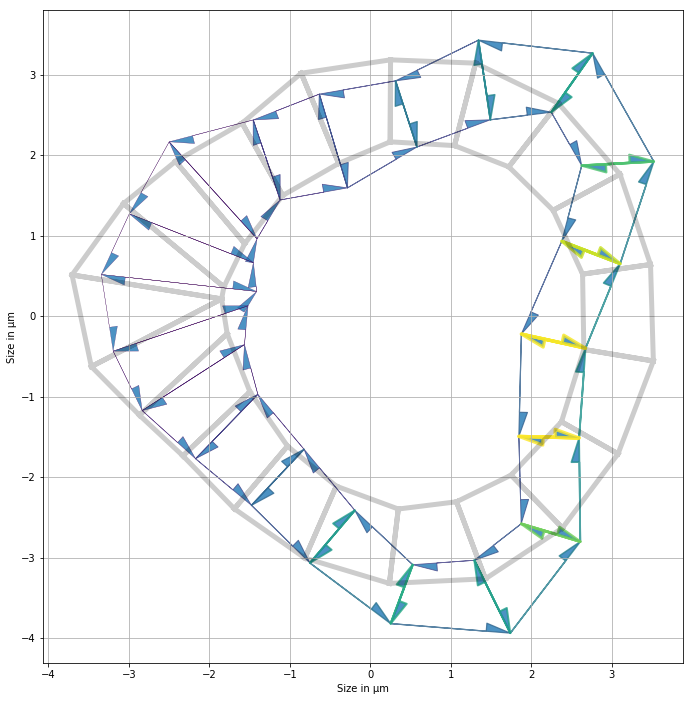

In [13]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area.copy() + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

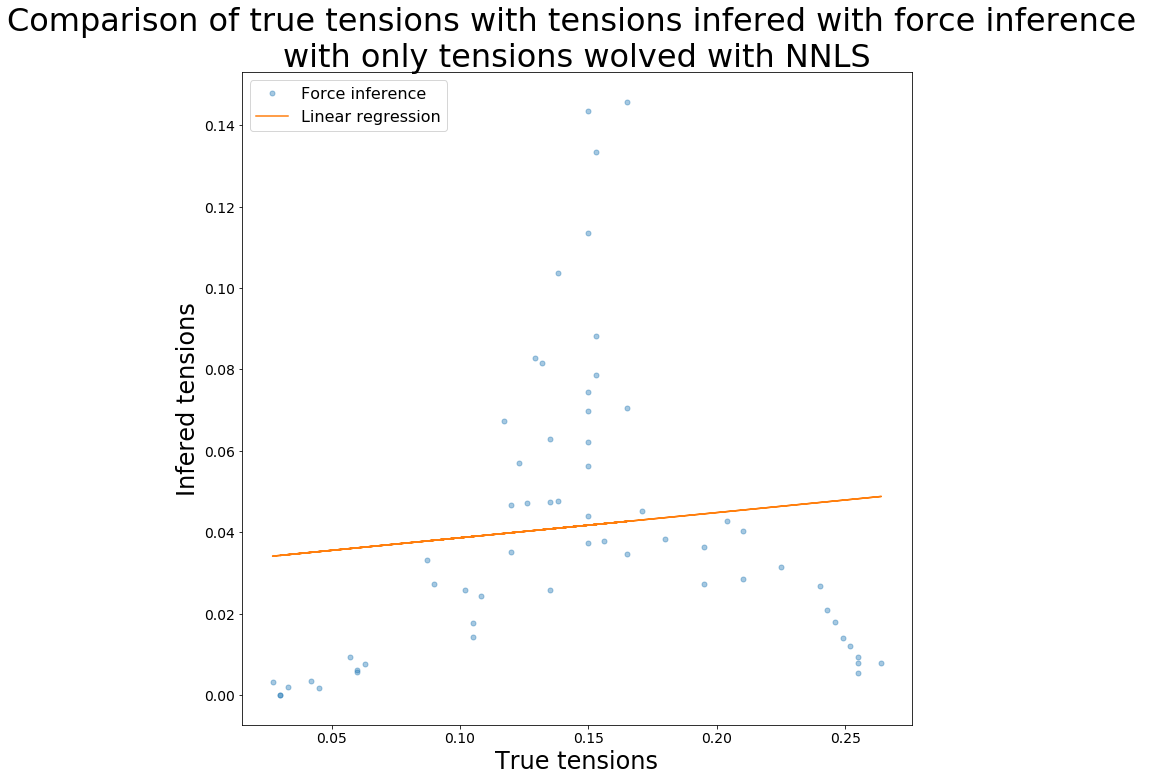

R value : 0.11226373126147732 
Standard error : 0.030459484449735702


In [14]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

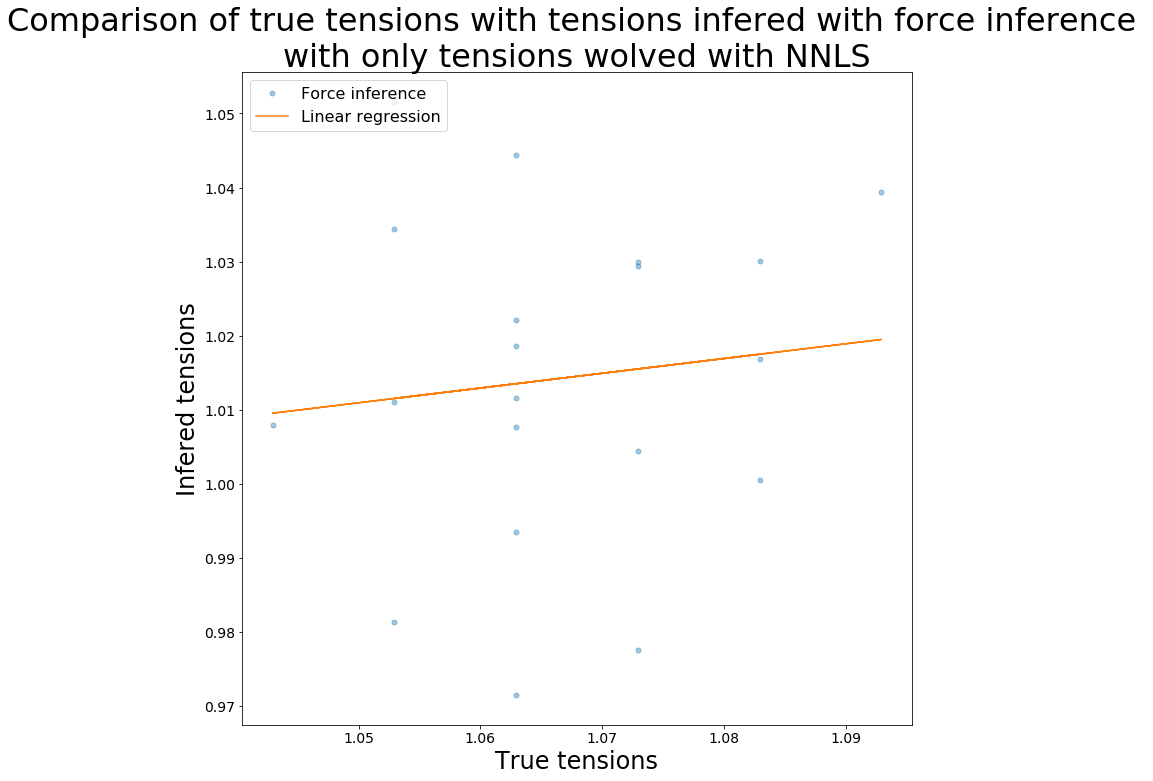

R value : 0.11458054518888981 
Standard error : 0.010666217314787082


In [15]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))